# Práctica de Sistemas Recomendadores: Surprise - iKNN

En este práctico vamos a utilizar la biblioteca de Python Surprise desarrollada por Nicolas Hug,, para aprender sobre Item KNN (Filtrado colaborativo basado en items)


**Profesor**: Denis Parra

**Ayudantes**:  Florencia Ferrer, Álvaro Labarca, Nicolás Sumonte, Jorge Facuse y Pablo Messina.



# Índice

>[Práctica de Sistemas Recomendadores: Surprise - iKNN](#scrollTo=NC-ceGb8LRLT)

>[Índice](#scrollTo=2j02H66f87eV)

>[Configuración Inicial](#scrollTo=I63yOG6sK6Lx)

>>[Descargando la información](#scrollTo=9qKTQ2V5VKSX)

>>[Revisar archivos descargados](#scrollTo=liJ3L2kl4g1o)

>>[Cómo ver la información de una o más películas](#scrollTo=jqXxj773Foo8)

>>[Instalar Surprise](#scrollTo=P3K5VPZoGSYX)

>[ItemKNN](#scrollTo=FqgkF0dNMo9c)

>>[Entrenar el modelo](#scrollTo=nyiS5jAydggW)

>>[Prediga el rating que le dará un usuario a un ítem](#scrollTo=c-tasjVmdj9Z)

>>[Genera una lista de recomendaciones para un usuario](#scrollTo=Ka67uLNmdoqD)

>>[Explorar los hiperparámetros del modelo ItemKnn](#scrollTo=or0YkBeF8eeC)

>>>[Evaluar en base a error de prediccion (RMSE y MAE)](#scrollTo=UamBnxcF1JBY)



# Configuración Inicial

Esta celda permite instalar una versión compatible de Numpy. Una vez que se pida reiniciar la sesión, no hay que volver a ejecutar esta celda.

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.25

## Descargando la información

Ejecutar cada celda presionando el botón de **Play** o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (OSX) para descargar las bases de datos.

In [ ]:
!pip install gdown

In [ ]:
!gdown 1UQ8JimYWfj2z0BQISccTWGoirptyVIHU

In [ ]:
!gdown 1weLy5CTQiW8ltH24UsK5Y5451NFKNd_N

In [ ]:
!gdown 13afMOhZGgIKLz784biKbvZ1rnM4iJzLk

Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, ítem, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [movielens](https://grouplens.org/datasets/movielens/).

## Revisar archivos descargados

Revisemos cómo es uno de estos archivos:

In [1]:
import pandas as pd

train_file = pd.read_csv('u1.base', sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [2]:
train_file[train_file['itemid'] == 1653]

,userid,itemid,rating,timestamp
54444,675,1653,5,889489913


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo.

In [3]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [10]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musical    

In [5]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.

## Cómo ver la información de una o más películas
Para esto se hace 2 pasos,
1. Determinar los índices de las películas.
2. Pedir a `info_file` las columnas.
3. (Adicional) Indicar alguna columna en específico.

In [6]:
# Ejemplo de cómo visualizar títulos de películas en base a sus IDs
pelis = [5,4,1]
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Para éste código:
1. `pelis = [5,4,1]` indica que queremos las películas cuyo índice son 5, 4 y 1.
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá cómo obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna.

In [7]:
info_file.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

## Instalar Surprise

Primero es necesario instalar una librería para realizar recomendaciones. Esta se llama Surprise

In [12]:
!pip install scikit-surprise --no-build-isolation --no-deps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505935 sha256=29ec789d08a9e44cae5d380edc8a69d92849213f60cd6818d22e5955de339404
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en este práctico

In [8]:
import surprise
import numpy as np
from collections import defaultdict

# ItemKNN

Probar método de recomendación basado en **ItemKNN**

Similar a lo que se hizo en el práctico de UserKNN, debemos convertir los datos para que sean soportados por la librería Surprise.

In [11]:
from surprise.model_selection import PredefinedKFold
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([("u1.base", "u1.test")], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

## Entrenar el modelo

Lo primero que se debe hacer es entrenar el modelo, con los datos descargados anteriormente.

In [12]:
# Declarar el objeto recomendador ItemKNN
from surprise import accuracy
myItemKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': False})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [13]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myItemKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Prediga el rating que le dará un usuario a un ítem

model_name.predict("user_id", "item_id")

In [15]:
myItemKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=4.571428571428571, details={'actual_k': 7, 'was_impossible': False})

## Genera una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando loc vista anteriormete)

Como se explicó en la ayudantía de UserKNN, para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [16]:
a_testset = trainset.build_anti_testset()
predictions = myItemKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [17]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [18]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('947', 5), ('1125', 5), ('1106', 5), ('1280', 5), ('1358', 5), ('1429', 5), ('1431', 5), ('1369', 5), ('1523', 5), ('74', 5)]


In [19]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
947,"Big Blue, The (Grand bleu, Le) (1988)",01-Jan-1988,NaN,"http://us.imdb.com/M/title-exact?Grand%20bleu,...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1125,"Innocents, The (1961)",01-Jan-1961,NaN,"http://us.imdb.com/M/title-exact?Innocents,%20...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1106,"Newton Boys, The (1998)",14-Mar-1998,NaN,"http://us.imdb.com/Title?Newton+Boys,+The+(1998)",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1280,Gang Related (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Gang+Related+...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1358,The Deadly Cure (1996),16-Sep-1996,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1429,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1431,Legal Deceit (1997),01-Jan-1997,NaN,http://us.imdb.com/Title?Legal+Deceit+(1997),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1369,"Forbidden Christ, The (Cristo proibito, Il) (1...",01-Jan-1950,NaN,http://us.imdb.com/M/title-exact?Cristo%20proi...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1523,"Good Man in Africa, A (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Good%20Man%20...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Explorar los hiperparámetros del modelo ***ItemKnn***

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Items), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

In [20]:
k_values = [5, 10, 30, 50, 70, 100] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myItemKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': False})
  myItemKnn.fit(trainset)
  predictions = myItemKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2026
MAE:  0.9458
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1183
MAE:  0.8810
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0535
MAE:  0.8310
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0474
MAE:  0.8257
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0489
MAE:  0.8294
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0528
MAE:  0.8364
RMSE: [1.2026497014602677, 1.1182690148176855, 1.053528288892625, 1.0474114308369047, 1.0488827603028315, 1.0527804024208793]
MAE: [0.9458074771899645, 0.8809797919490109, 0.830956196694298, 0.8257379441539587, 0.8293620137533942, 0.8363912329141866]


### Evaluar en base a error de prediccion (RMSE y MAE)

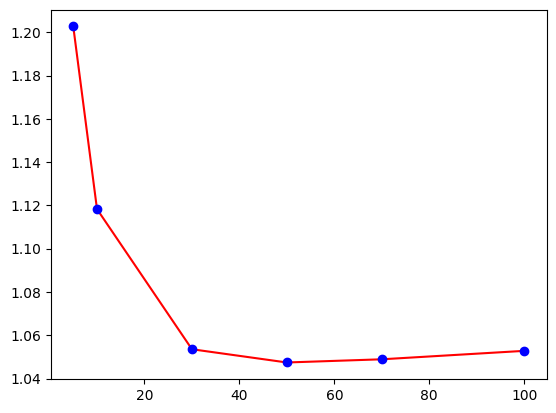

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

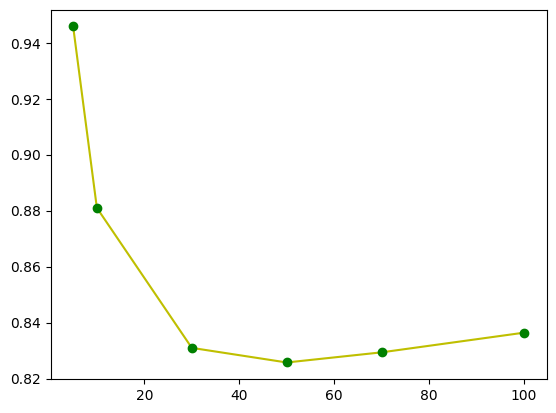

In [22]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.show()

**Ejercicio 1**

Según los resultados, ¿Qué número de vecinos es mejor para hacer recomendaciones con un menor error de predicción? Muestre el top 10 de películas a recomendar al usuario de ID 457*.

*Si identifica más de un valor de k posible, realice la recomendación para para ambos valores.

In [23]:
ganador = []
for k, rmse, mae in zip(k_values, rmse_values, mae_values):
    ganador.append((k, rmse, mae))
ganador.sort(key=lambda x: x[1])
print(f'Ganador RMSE: k={ganador[0][0]}')
ganador.sort(key=lambda x: x[2])
print(f'Ganador MAE: k={ganador[0][0]}')

Ganador RMSE: k=50
Ganador MAE: k=50


Volvio a ganar k = 50 al igual que para el user based.

In [24]:
myItemKnn = surprise.KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})
myItemKnn.fit(trainset)
predictions = myItemKnn.test(a_testset)
top_n = get_top_n(predictions, n=10)
print(top_n["457"])
pelis_userKnn = np.array([m[0] for m in top_n["457"]]).astype(int)
info_file.loc[pelis_userKnn]['title']

Computing the cosine similarity matrix...
Done computing similarity matrix.
[('1360', 4.791666666666667), ('1593', 4.791666666666667), ('1674', 4.72), ('1332', 4.717948717948718), ('1377', 4.7), ('1201', 4.68), ('603', 4.679924497224236), ('1609', 4.66), ('1455', 4.66), ('1656', 4.66)]


movieid
1360              Sexual Life of the Belgians, The (1994)
1593                            Death in Brunswick (1991)
1674                                    Mamma Roma (1962)
1332    My Life and Times With Antonin Artaud (En comp...
1377                                 Hotel de Love (1996)
1201           Marlene Dietrich: Shadow and Light (1996) 
603                                    Rear Window (1954)
1609                                       B*A*P*S (1997)
1455                                   Outlaw, The (1943)
1656                                   Little City (1998)
Name: title, dtype: object

In [26]:
top_10_k50_users = [('1122', 5), ('1201', 5), ('1293', 5), ('1175', 5), ('1467', 5), ('1189', 5), ('1599', 5), ('1653', 5), ('1656', 5), ('1500', 5)]
top_10_k50_items = [('1360', 4.791666666666667), ('1593', 4.791666666666667), ('1674', 4.72), ('1332', 4.717948717948718), ('1377', 4.7), ('1201', 4.68), ('603', 4.679924497224236), ('1609', 4.66), ('1455', 4.66), ('1656', 4.66)]
contador = 0
for tupla in top_10_k50_users:
    if tupla not in top_10_k50_items:
        contador += 1         
print(f'Cantidad de peliculas recomendadas por usuario que no estan en la lista recomendada por item: {contador}/10')


Cantidad de peliculas recomendadas por usuario que no estan en la lista recomendada por item: 10/10


Todas las peliculas recomendadas fueron distintas que cuando se comparo con usuarios.

**Ejercicio 2**

Realice el mismo análisis hecho previamente utilizando como métrica de similaridad *pearson* para identificar el mejor número de vecinos. Compare sus resultados con los obtenidos en el ejercicio 1 y comentelos. ¿El mejor número de vecinos es el mismo? ¿Cambia la lista de recomendación?

In [27]:
k_values = [5, 10, 30, 50, 70, 100] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myItemKnn = surprise.KNNBasic(k=k, sim_options={'name': 'pearson', 'user_based': False})
  myItemKnn.fit(trainset)
  predictions = myItemKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1946
MAE:  0.9555
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1217
MAE:  0.8992
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0653
MAE:  0.8521
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0559
MAE:  0.8434
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0524
MAE:  0.8402
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0507
MAE:  0.8387
RMSE: [1.1945816652426113, 1.1216752083867862, 1.06532972422841, 1.0559434737660751, 1.0524301470241026, 1.050667970802885]
MAE: [0.9555470180787997, 0.8991681591159879, 0.8521342075955847, 0.8433924514915973, 0.8402481829301348, 0.8387299206837521]


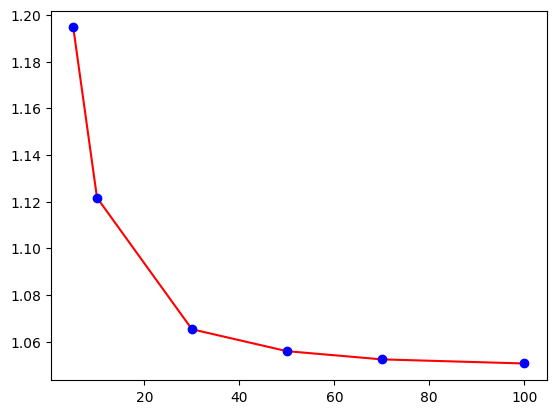

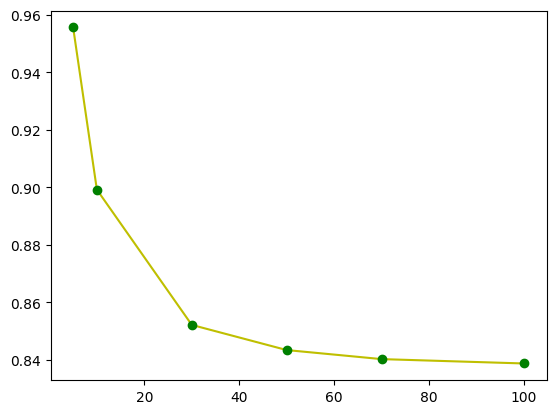

In [28]:
plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.show()

In [29]:
ganador = []
for k, rmse, mae in zip(k_values, rmse_values, mae_values):
    ganador.append((k, rmse, mae))
ganador.sort(key=lambda x: x[1])
print(f'Ganador RMSE: k={ganador[0][0]}')
ganador.sort(key=lambda x: x[2])
print(f'Ganador MAE: k={ganador[0][0]}')

Ganador RMSE: k=100
Ganador MAE: k=100


Utilizando la similaridad de pearson el error es menor a los 100 vecinos. Por lo que mas vecinos es mejor, a diferencia del ejercicio 1 donde 50 vecinos minimizaba el error.

In [30]:
myItemKnn = surprise.KNNBasic(k=100, sim_options={'name': 'pearson', 'user_based': False})
myItemKnn.fit(trainset)
predictions = myItemKnn.test(a_testset)
top_n = get_top_n(predictions, n=10)
print(top_n["457"])
pelis_userKnn = np.array([m[0] for m in top_n["457"]]).astype(int)
info_file.loc[pelis_userKnn]['title']

Computing the pearson similarity matrix...
Done computing similarity matrix.
[('1125', 5), ('1106', 5), ('1358', 5), ('1429', 5), ('1431', 5), ('1369', 5), ('1523', 5), ('1294', 5), ('626', 5), ('1545', 5)]


movieid
1125                                Innocents, The (1961)
1106                              Newton Boys, The (1998)
1358                               The Deadly Cure (1996)
1429                                 Sliding Doors (1998)
1431                                  Legal Deceit (1997)
1369    Forbidden Christ, The (Cristo proibito, Il) (1...
1523                         Good Man in Africa, A (1994)
1294                     Ayn Rand: A Sense of Life (1997)
626                            So Dear to My Heart (1949)
1545                             Frankie Starlight (1995)
Name: title, dtype: object

In [31]:
top_10_k50_items = [('1360', 4.791666666666667), ('1593', 4.791666666666667), ('1674', 4.72), ('1332', 4.717948717948718), ('1377', 4.7), ('1201', 4.68), ('603', 4.679924497224236), ('1609', 4.66), ('1455', 4.66), ('1656', 4.66)]
top_10_k100_items = [('1125', 5), ('1106', 5), ('1358', 5), ('1429', 5), ('1431', 5), ('1369', 5), ('1523', 5), ('1294', 5), ('626', 5), ('1545', 5)]

contador = 0
for tupla in top_10_k50_items:
    if tupla not in top_10_k100_items:
        contador += 1         
print(f'Cantidad de peliculas recomendadas 50 vecinos que no estan en la lista recomendada con 100 vecinos: {contador}/10')

Cantidad de peliculas recomendadas 50 vecinos que no estan en la lista recomendada con 100 vecinos: 10/10


Como se puede ver la lista de recomendación cambio totalmente, ya que no se repite ninguna pelicula.